In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cobra
import numpy as np
import seaborn as sns

In [2]:
sns.hls_palette

<function seaborn.palettes.hls_palette(n_colors=6, h=0.01, l=0.6, s=0.65, as_cmap=False)>

# Estimate Vmax from the literature

In [3]:
# Best fit Vmax ammonium
Vmax_ammonium_raw = 1.05*1e-9 # umol/cell/day
Vmax_ammonium_day = Vmax_ammonium_raw/(66*1e-15) #umol/gDW/day 
Vmax_ammonium_hour = Vmax_ammonium_day/24 #umol/gDW/h
Vmax_ammonium = Vmax_ammonium_hour*1e-3 # mmol/gDW/h
print(Vmax_ammonium)

0.6628787878787878


In [4]:
# Literature value Vmax ammonium
Vmax_ammonium_raw = 0.11*1e-9 # umol/cell/day
Vmax_ammonium_day = Vmax_ammonium_raw/(66*1e-15) #umol/gDW/day 
Vmax_ammonium_hour = Vmax_ammonium_day/24 #umol/gDW/h
Vmax_ammonium = Vmax_ammonium_hour*1e-3 # mmol/gDW/h
print(Vmax_ammonium)



0.06944444444444445


In [5]:
# Calculate Vmax
N_growth_yield = 0.1166 #gDW/mmol NH3
Km_ammonium = 0.35*1e-3 #mM
observed_growth_rate = 0.4 #/day
observed_death_rate = 0.1 #/day
gross_growth_rate = observed_death_rate + observed_growth_rate
gross_gr_hour = gross_growth_rate/24
N_conc = 0.1 #mM

def Vmax(Km, conc, N_yield, growth_rate):
    return (growth_rate/N_yield)*(Km+conc)/conc

print("Ammonium Vmax: ", Vmax(Km_ammonium, N_conc, N_growth_yield, gross_gr_hour))
#print("Ammonium Vmax: ", Vmax(Km_ammonium, N_conc, N_growth_yield, observed_growth_rate/24))

Ammonium Vmax:  0.17929888507718697


# Import model and identify yields

In [6]:
model_fn = "C:\\Users\\snorres\\git\\iSO595\\Model_files\\iSO595v6.xml"
#model_fn = "C:/Users/snorres/git/MarinePro/Models/Prochlorococcus/iSO595/Model_files/iSO595v4py.xml"
model = cobra.io.read_sbml_model(model_fn)


Using license file C:\Users\snorres\gurobi.lic
Academic license - for non-commercial use only


In [7]:
with model:
    model.reactions.LightEX.lower_bound = -19.4
    model.optimize()
    print(model.summary(threshold = 1e-5))
    light_yield = -model.reactions.BiomassEX.flux/model.reactions.LightEX.flux
    print(light_yield)

     IN_FLUXES       IN_FLUXES          OUT_FLUXES          OUT_FLUXES OBJECTIVES OBJECTIVES
         ID             FLUX                ID                 FLUX        ID        FLUX   
           Photon[e]      19.4                         H[e]      1.32    BIOMASS    0.0206  
             HCO3[e]       1.1                    Oxygen[e]      1.19                  nan  
          Ammonia[e]     0.179                       H2O[e]      0.89                  nan  
 Hydrogen_sulfide[e]    0.0104                       CO2[e]    0.0683                  nan  
    Sodium_cation[e]   0.00908                   biomass[e]    0.0206                  nan  
   Orthophosphate[e]    0.0074         Hydrogen_peroxide[e]   0.00227                  nan  
          Sulfate[e]   0.00507  S_Methyl_5_thio_D_ribose[e]  0.000927                  nan  
     Chloride_ion[e]   0.00484                      Urea[e]  0.000927                  nan  
 Magnesium_cation[e]   0.00324                                    nan 

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


In [8]:
with model:
    model.reactions.LightEX.lower_bound = -100
    model.reactions.AmmoniaEX.lower_bound = -10
    model.reactions.CO2EX.bounds = (0, 0.818)
    model.optimize()
    print(model.summary(threshold = 1e-5))
    ammonium_yield = -model.reactions.BiomassEX.flux/model.reactions.AmmoniaEX.flux
    print(ammonium_yield)

     IN_FLUXES       IN_FLUXES          OUT_FLUXES          OUT_FLUXES OBJECTIVES OBJECTIVES
         ID             FLUX                ID                 FLUX        ID        FLUX   
           Photon[e]      100                          H[e]     6.76     BIOMASS    0.0997  
             HCO3[e]     5.34                     Oxygen[e]     6.02                   nan  
          Ammonia[e]    0.864                        H2O[e]     4.38                   nan  
          Sulfate[e]    0.238                        CO2[e]     0.33                   nan  
    Sodium_cation[e]   0.0439                    biomass[e]   0.0997                   nan  
   Orthophosphate[e]   0.0358                Thiosulfate[e]   0.0817                   nan  
     Chloride_ion[e]   0.0234          Hydrogen_peroxide[e]    0.011                   nan  
 Magnesium_cation[e]   0.0156   S_Methyl_5_thio_D_ribose[e]  0.00448                   nan  
                K[e]  0.00937                       Urea[e]  0.00448  

cobra\core\summary\summary.py:206 UserWarning: Setting float_format to anything other than None will cause nan to be present in the output.


In [9]:
model.reactions.CO2EX

Reaction identifier,CO2EX
Name,CO2 Exchange
Memory address,0x0214b4a59278
Stoichiometry,CO2[e] <=> CO2 <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


# Define parameters for sensitivity analysis

In [10]:
N_growth_yield = 0.1166 #gDW/mmol NH3
light_growth_yield = 0.00106 # gDW / mmol photons
N_concentration = 0.1 #mM

In [58]:
def light(I, X, a_b, a_w, dz):
    return 3600*I*a_b*(1-np.exp(-dz*(a_w+(a_b*X))))/(dz*(a_w+(a_b*X)))

In [12]:
a_b = 0.2846 #m^2/gDW
a_w = 0.465 
dz = 0.01 #m

In [13]:
grid_size = 1 #cm
grid_volume_cm3 = grid_size**3 #Cubic centimeters
grid_volume = grid_volume_cm3*1e-3 # Convert from cubic centimeters to L
cell_weight = 66*1e-15 #g per cell (Cermak et al., 2017)
initial_pop = 1.3e9*cell_weight*grid_volume # gDW/L

In [63]:
light(0.04, X, a_b, a_w, dz)

40.9823794598984

In [15]:
40.04*light_growth_yield

0.0424424

In [16]:
def MM(Vmax, Km, concentration):
    return Vmax*(concentration)/(Km + concentration)

In [17]:
MM(0.9,0.39,0.1)


0.18367346938775514

# Real ammonium concentrations

In [18]:
# http://www.aari.ru/docs/pub/060922/ree06.pdf
# ammonium in the atlantic ocean
nh4_conc = 0.109# uMol +-0.15 uMol
    

In [19]:
Vmax = np.arange(0, 1.2, 0.1) # mmol 
Km = np.logspace(-4,0.1, 41)
growth_rate_Nlim = np.zeros((len(Vmax), len(Km)))
growth_rate_Nabund = np.zeros((len(Vmax), len(Km)))
growth_rate_Natlantic = np.zeros((len(Vmax), len(Km)))
max_growth = 0.0997
with model:
    for i, vi in enumerate(Vmax):
        for j, kj in enumerate(Km):
            growth_rate_Nlim[i,j] = MM(vi, kj, 0.1)*N_growth_yield
            growth_rate_Nabund[i,j] = MM(vi, kj, 0.8)*N_growth_yield
            growth_rate_Natlantic[i,j] = MM(vi, kj, 0.109*1e-3)*N_growth_yield
            
light_Nlim = growth_rate_Nlim/light_growth_yield
light_Nabund = growth_rate_Nabund/light_growth_yield
light_Natlantic = growth_rate_Natlantic/light_growth_yield

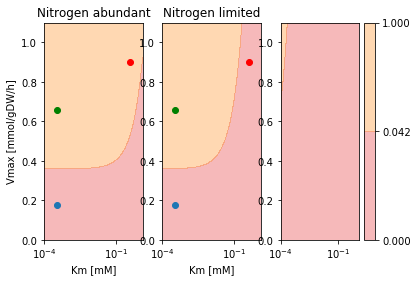

In [20]:
xx, yy = np.meshgrid(Km, Vmax)
fig, [ax1,ax2, ax3] = plt.subplots(1,3, sharex = True)
a = ax1.contourf(xx,yy, growth_rate_Nabund, levels = [0, 0.042,1], alpha = 0.3, cmap = "Set1")
ax1.set_xscale("log")
ax2.contourf(xx,yy, growth_rate_Nlim, levels = [0, 0.042,1], alpha = 0.3, cmap = "Set1")
#ax2.set_xscale("log")
ax3.contourf(xx,yy, growth_rate_Natlantic, levels = [0, 0.042,1], alpha = 0.3, cmap = "Set1")
#ax3.set_xscale("log")


ax1.scatter(0.35*1e-3, 0.179)
ax2.scatter(0.35*1e-3, 0.179)
ax1.scatter(0.39, 0.9, color = "r")
ax2.scatter(0.39, 0.9, color = "r")
ax1.scatter(0.35*1e-3, 0.66, color = "g")
ax2.scatter(0.35*1e-3, 0.66, color = "g")
ax1.set_xlabel("Km [mM]")
ax2.set_xlabel("Km [mM]")
ax1.set_ylabel("Vmax [mmol/gDW/h]")
ax2.set_title("Nitrogen limited")
ax1.set_title("Nitrogen abundant")

cbar = plt.colorbar(a)
#CS = plt.contour(xx,yy, growth_rate*24, levels = [0.04*24], colors = 'r')

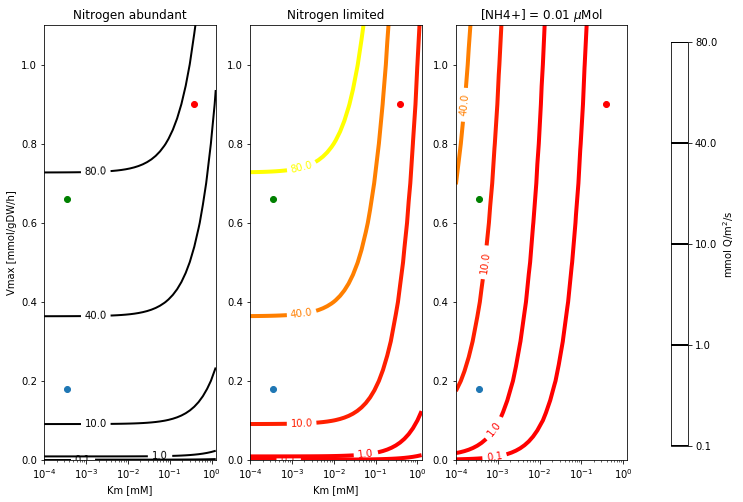

In [36]:
xx, yy = np.meshgrid(Km, Vmax)
fig, [ax1,ax2, ax3] = plt.subplots(1,3, sharex = True, figsize = (12, 8))
CS1 = ax1.contour(xx,yy, light_Nabund, levels = [0.1,1, 10, 40, 80], alpha = 1, colors = "k", linewidths = 2)
ax1.set_xscale("log")
CS2 = ax2.contour(xx,yy, light_Nlim, levels = [0.1,1, 10, 40, 80], alpha = 1, cmap = "autumn", linewidths = 4)
CS3 = ax3.contour(xx,yy, light_Natlantic, levels = [0.1,1, 10, 40, 80], alpha = 1, cmap = "autumn", linewidths = 4)
ax1.clabel(CS1, inline = 1, fontsize = 10,  fmt='%1.1f')
ax2.clabel(CS2, inline = 1, fontsize = 10,  fmt='%1.1f')
ax3.clabel(CS3, inline = 1, fontsize = 10,  fmt='%1.1f')
ax1.scatter(0.35*1e-3, 0.179, zorder = 3)
ax2.scatter(0.35*1e-3, 0.179, zorder = 3)
ax3.scatter(0.35*1e-3, 0.179, zorder = 3)
ax1.scatter(0.39, 0.9, color = "r", zorder = 3)
ax2.scatter(0.39, 0.9, color = "r", zorder = 3)
ax3.scatter(0.39, 0.9, color = "r", zorder = 3)
ax1.scatter(0.35*1e-3, 0.66, color = "g", zorder = 3)
ax2.scatter(0.35*1e-3, 0.66, color = "g", zorder = 3)
ax3.scatter(0.35*1e-3, 0.66, color = "g", zorder = 3)
ax1.set_xlabel("Km [mM]")
ax2.set_xlabel("Km [mM]")
ax1.set_ylabel("Vmax [mmol/gDW/h]")
ax2.set_title("Nitrogen limited")
ax3.set_title("[NH4+] = 0.01 $\mu$Mol")
ax1.set_title("Nitrogen abundant")
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(CS1, cax=cbar_ax)
cbar.set_label('mmol Q/m$^2$/s')


In [22]:
# PAR
#https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015GB005139
# https://oceancolor.gsfc.nasa.gov/atbd/par/
PAR_average = 

SyntaxError: invalid syntax (<ipython-input-22-6fb9111ac994>, line 4)